# tmp — jul24

**Motivation**: scratch notebook <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

In [3]:
def split_data(
		n_samples: int,
		n_blocks: int = 1,
		vld_portion: float = 0.2, ):
	assert 0 < vld_portion < 1
	indices = range(n_samples)
	block_size = len(indices) // n_blocks

	trn_inds, vld_inds = [], []
	for b in range(n_blocks):
		start = b * block_size
		if b == n_blocks - 1:
			end = len(indices)
		else:
			end = start + block_size

		block_inds = indices[start:end]
		vld_size = np.round(len(block_inds) * vld_portion)
		trn_size = len(block_inds) - int(vld_size)

		trn_inds.extend(block_inds[:trn_size])
		vld_inds.extend(block_inds[trn_size:])

	assert not set(trn_inds).intersection(
		vld_inds), "must be non-overlapping"
	trn_inds, vld_inds = map(
		lambda x: np.array(x),
		[trn_inds, vld_inds],
	)
	return trn_inds, vld_inds

In [4]:
train, validation = split_data(128956, 10, 0.2)
print("Train indices:", len(train))
print("Validation indices:", len(validation))

Train indices: 103165

Validation indices: 25791

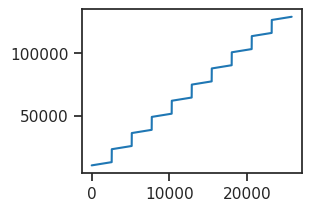

In [5]:
fig, ax = create_figure()
ax.plot(validation);

In [6]:
mu = torch.randn(1000, 512).to(device)
var = torch.randn(1000, 512).to(device)
x = torch.randn(1000, 256).to(device)

phi = torch.randn(256, 512).to(device)
a = phi.pow(2).sum(0)
a.shape

torch.Size([512])

In [7]:
term1 = x - mu @ phi.T
term1 = term1.pow(2).sum(1)
term2 = var @ a

In [12]:
def f1():
    term1 = x - mu @ phi.T
    term1 = term1.pow(2).sum(1)
    return term1


def f2():
    term1 = x - mu @ phi.T
    term1 = torch.linalg.vector_norm(term1, dim=1).pow(2)
    return term1


def f3():
    term1 = x - mu @ phi.T
    term1 = torch.linalg.norm(term1, dim=1).pow(2)
    return term1

In [30]:
%timeit f1()

32.7 µs ± 33.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
%timeit f2()

33.5 µs ± 98.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%timeit f3()

33.7 µs ± 67.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
